In [1]:
pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

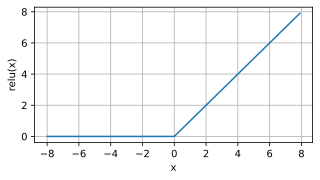

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad = True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize = (5, 2.5))

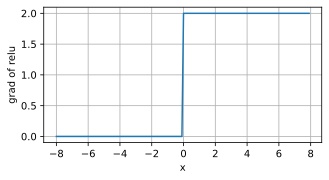

In [ ]:
y.backward(torch.ones_like(x), retain_graph = True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize = (5, 2.5))

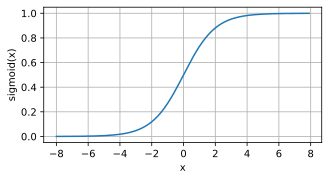

In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize = (5, 2.5))

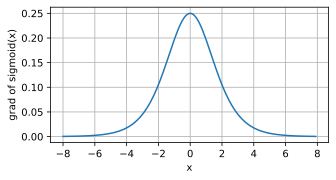

In [ ]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph = True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid(x)', figsize = (5, 2.5))

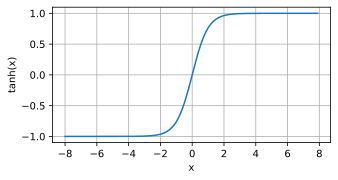

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize = (5, 2.5))

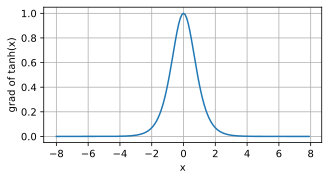

In [ ]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph = True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh(x)', figsize = (5, 2.5))

多层感知机从零实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad = True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad = True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad = True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad = True))
params = [W1, b1, W2, b2]

In [ ]:
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(X, a)

In [ ]:
def net(X):
  X = X.reshape((-1, num_inputs))
  H = relu(X @ W1 + b1)
  return (H @ W2 + b2)

In [ ]:
loss = nn.CrossEntropyLoss()

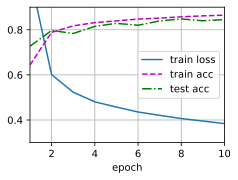

In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr = lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


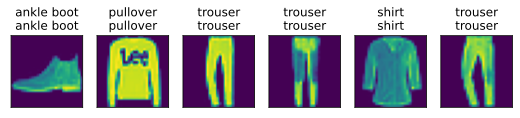

In [ ]:
d2l.predict_ch3(net, test_iter)

多层感知机简单实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784, 256), nn.ReLU(), nn.Linear(256,10))
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)
net.apply(init_weights);

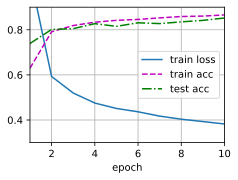

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr = lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

多项式回归

In [ ]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0 : 4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
  poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1, size = labels.shape)

In [ ]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype = torch.float32)
for x in [true_w, features, poly_features, labels]]


In [ ]:
def evaluate_loss(net, data_iter, loss):
  metric = d2l.Accumulator(2)
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels, num_epochs = 400):
  loss = nn.MSELoss()
  input_shape = train_features.shape[-1]
  net = nn.Sequential(nn.Linear(input_shape, 1, bias = False))
  batch_size = min(10, train_labels.shape[0])
  train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
  test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train = False)
  trainer = torch.optim.SGD(net.parameters(), lr = 0.01)
  animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss', yscale = 'log', xlim = [1, num_epochs],
                          ylim = [1e-3, 1e2], legend = ['train', 'test'])
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch + 1)% 20 == 0:
      animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
  print('weight:', net[0].weight.data.numpy())

weight: [[ 4.990088   1.2181896 -3.3871202  5.5770082]]


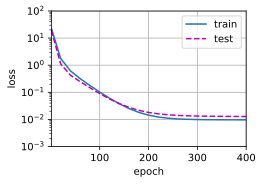

In [ ]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.3174016 3.5501025]]


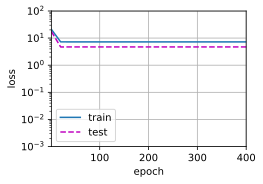

In [ ]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.980674    1.272379   -3.329037    5.1889806  -0.18258148  1.2453853
   0.2356859   0.26852965  0.1429483  -0.00894436  0.12076247 -0.14448187
   0.06922756 -0.2072043  -0.2231153  -0.04259795 -0.21131124 -0.15443584
  -0.07453012 -0.20379536]]


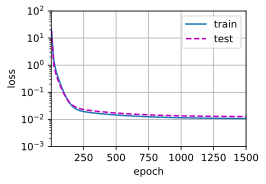

In [ ]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

In [ ]:
poly_features[:n_train, :].shape

torch.Size([100, 20])

权重衰减

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
%matplotlib inline

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size)

In [ ]:
def init_params():
  w = torch.normal(0, 1,size = (num_inputs, 1), requires_grad = True)
  b =torch.zeros(1, requires_grad = True)
  return [w, b]

In [ ]:
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.699323654174805


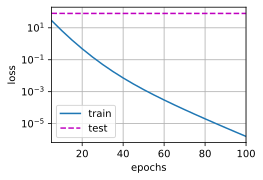

In [ ]:
train(lambd = 0)

w的L2范数是： 0.33884596824645996


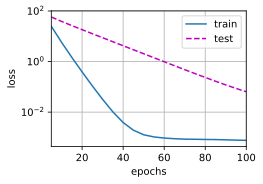

In [ ]:
train(lambd=3)

In [ ]:
def train_concise(wd):
  net = nn.Sequential(nn.Linear(num_inputs, 1))
  for param in net.parameters():
        param.data.normal_()
  loss = nn.MSELoss()
  num_epochs, lr = 100, 0.003
  trainer = torch.optim.SGD([{
      "params" : net[0].weight,
      'weight_decay':wd
  },{
      "params" : net[0].bias
  }], lr = lr)
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
               xlim=[5, num_epochs], legend = ['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with torch.enable_grad():
        trainer.zero_grad()
        l = loss(net(X), y)
      l.backward()
      trainer.step()
    if (epoch + 1)%5 == 0:
      animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                    d2l.evaluate_loss(net, test_iter, loss)))
  print(net[0].weight.norm().item())

13.255313873291016


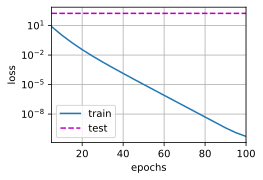

In [ ]:
train_concise(0)

0.35668572783470154


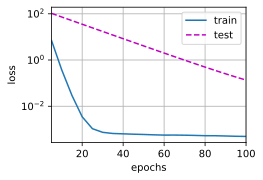

In [ ]:
train_concise(3)

dropout

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

#实现dropout
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  if dropout == 1:
    return torch.zeros_like(X)
  if dropout == 0:
    return X
  mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
  return mask * X / (1.0 - dropout)

In [8]:
#定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training = True):
    super(Net, self).__init__()
    self.num_inputs = num_inputs
    self.training = is_training
    self.lin1 = nn.Linear(num_inputs, num_hiddens1)
    self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
    self.lin3 = nn.Linear(num_hiddens2, num_outputs)
    self.relu = nn.ReLU()
  def forward(self, X):
    H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
    if self.training == True:
      H1 = dropout_layer(H1, dropout1)
    H2 = self.relu(self.lin2(H1))
    if self.training == True:
      H2 = dropout_layer(H2, dropout2)
    out = self.lin3(H2)
    return out
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

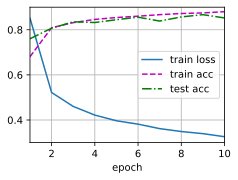

In [9]:
#训练
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr = lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [15]:
#简洁实现
net == nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
nn.Dropout(dropout2), nn.Linear(256, 10))
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)
net.apply(init_weights)

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

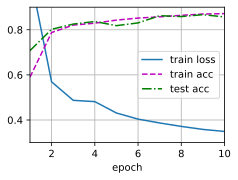

In [17]:
#训练
trainer = torch.optim.SGD(net.parameters(), lr = lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)